In [160]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [161]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [162]:
### Read CSV
df = pd.read_csv("/kaggle/input/dataset/BBBP.csv")
df['SMILES_Length'] = df['smiles'].apply(lambda x: len(x))

display(df)

,num,name,p_np,smiles,SMILES_Length
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,32
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,40
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,50
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,32
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,66
...,...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl,47
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...,87
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...,53
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...,63


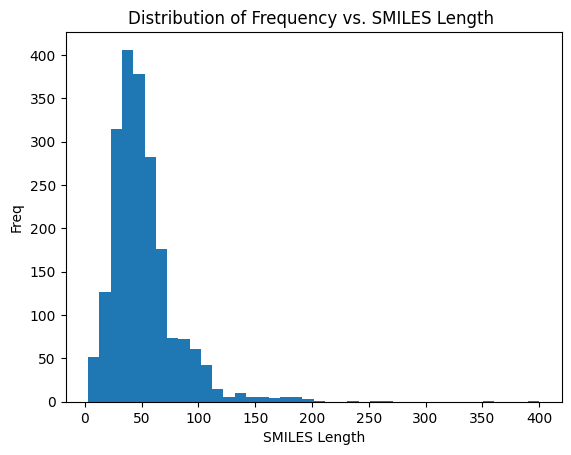

In [163]:
# Plot Distribution of SMILES strings
plt.hist(df['SMILES_Length'], bins=40)
plt.title('Distribution of Frequency vs. SMILES Length ')
plt.xlabel('SMILES Length')
plt.ylabel('Freq')
plt.show()

In [164]:
smiles = list(df['smiles'])
all_chars = "".join(smiles)
unique_chars = set(all_chars)
unique_chars = list(unique_chars)
print(unique_chars)
print("The number of unique character is "  , len(unique_chars))

['C', 'H', '0', 'S', 'O', 'l', '[', '.', '2', '-', '1', '3', 'c', ')', 'n', '@', 'B', '/', '9', '7', 'I', ']', '=', 'r', 'o', 'N', '8', 'a', '4', '+', 's', 'P', '5', '%', '6', '(', '\\', 'F', '#']
The number of unique character is  39


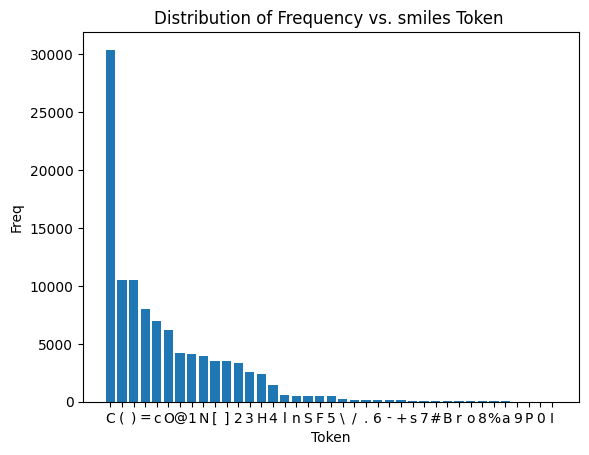

In [165]:
# split smiles strings and group by them.
df_exploded = df['smiles'].apply(list).explode()
character_counts = df_exploded.value_counts()

# Plot the distribution of token frequencies
plt.bar(character_counts.index, character_counts.values)
plt.title('Distribution of Frequency vs. smiles Token ')
plt.xlabel('Token')
plt.ylabel('Freq')
plt.show()

In [166]:
encoder = OneHotEncoder(categories=[unique_chars], sparse_output=False)
def one_hot_encoder(compound: str): 
    chars = list(compound)
    encoded = encoder.fit_transform([[c] for c in chars])
    return encoded.flatten()

df['One_Hot_Encoded'] = df['smiles'].apply(one_hot_encoder)
display(df)

,num,name,p_np,smiles,SMILES_Length,One_Hot_Encoded
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,32,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,40,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,50,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,32,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,66,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
2045,2049,licostinel,1,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl,47,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2046,2050,ademetionine(adenosyl-methionine),1,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...,87,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2047,2051,mesocarb,1,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...,53,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2048,2052,tofisoline,1,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...,63,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [167]:
### dataframe series to tensors and padding the input tensor to get the same shape for all tensors.
tensor_list = [torch.tensor(arr) for arr in df['smiles'].apply(one_hot_encoder)]
padded_data = pad_sequence(tensor_list, batch_first=True, padding_value=0)
labels_tensor = torch.Tensor(df['p_np']).view(-1, 1)  
### Split data to train and test 
X, _, Y, _ = train_test_split(
    padded_data, labels_tensor  , test_size=0.0001, random_state=42)

In [168]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs.to(torch.float32)
        self.labels = labels.to(torch.float32)
#         self.length_tensor = length_tensor.to(torch.float32)


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]


In [169]:
# Training Function
def train(model, train_loader, val_loader, num_epochs=1, learning_rate=1e-3):
#     criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predicted_labels = (outputs > 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = correct_predictions / total_samples
        print(f'Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss}, Accuracy: {accuracy}')
        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted_labels = (outputs > 0.5).float()
                labels = labels.to(torch.int)
                predicted_labels = predicted_labels.to(torch.int)  
                # Accuracy on validation set
                correct_predictions_valid = (predicted_labels == labels).sum().item()
                total_samples_valid = labels.size(0)
                
        # Store the AUC score in the list
        accuracy = correct_predictions_valid / total_samples_valid
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy}')


In [170]:
# MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)
#         return x

# Train MLP model. 

In [171]:
kf = KFold(n_splits=5)

for idx, (train_index, valid_index) in enumerate(kf.split(X)):
    print(f'{idx + 1}-th fold ')
    # Create and train the MLP model
    input_size = padded_data.shape[1]
    mlp_model = MLPModel(input_size).to(device)
    X_train, X_test = X[train_index], X[valid_index]
    y_train, y_test = Y[train_index], Y[valid_index]
    
    # Create dataset and data loader
    
    train_dataset = CustomDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    valid_dataset = CustomDataset(X_test, y_test)
    valid_loader = DataLoader(valid_dataset, batch_size = X_test.shape[0], shuffle=True)
    
    # train the model
    train(mlp_model, train_loader, valid_loader, num_epochs=10)


1-th fold 
Epoch [1/10], Avg Loss: 0.015683545198580198, Accuracy: 0.7571690054911532
Epoch [1/10], Validation Accuracy: 0.8414634146341463
Epoch [2/10], Avg Loss: 0.008735900766388392, Accuracy: 0.8840756558877364
Epoch [2/10], Validation Accuracy: 0.8560975609756097
Epoch [3/10], Avg Loss: 0.006027601359274564, Accuracy: 0.9194630872483222
Epoch [3/10], Validation Accuracy: 0.8609756097560975
Epoch [4/10], Avg Loss: 0.004511502731075514, Accuracy: 0.9481391092129348
Epoch [4/10], Validation Accuracy: 0.8707317073170732
Epoch [5/10], Avg Loss: 0.003559447199906279, Accuracy: 0.959731543624161
Epoch [5/10], Validation Accuracy: 0.8707317073170732
Epoch [6/10], Avg Loss: 0.0027621639432195777, Accuracy: 0.9725442342892008
Epoch [6/10], Validation Accuracy: 0.8609756097560975
Epoch [7/10], Avg Loss: 0.002178700866951602, Accuracy: 0.9816961561928005
Epoch [7/10], Validation Accuracy: 0.8658536585365854
Epoch [8/10], Avg Loss: 0.00180327691606009, Accuracy: 0.9847467968273338
Epoch [8/10]

# Define LSTM model. 

In [172]:
# LSTM Model with FC Layer
class LSTMFCModel(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, fc_hidden_size):
        super(LSTMFCModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_out = self.fc1(lstm_out)
        fc_out = self.relu(fc_out)
        output = self.fc2(fc_out)
        return torch.sigmoid(output)


# Train LSTM model. 

In [173]:
input_size = 15600 
hidden_size = 512
lstm_layers = 1
fc_hidden_size = 64
for idx, (train_index, valid_index) in enumerate(kf.split(X)):
    print(f'{idx + 1}-th fold ')
    # Create and train the MLP model
    input_size = X.shape[1]
    lstm_fc_model = LSTMFCModel(input_size, hidden_size, lstm_layers, fc_hidden_size).to(device)
    X_train, X_test = X[train_index], X[valid_index]
    y_train, y_test = Y[train_index], Y[valid_index]
    
    # Create dataset and data loader
    
    train_dataset = CustomDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    valid_dataset = CustomDataset(X_test, y_test)
    valid_loader = DataLoader(valid_dataset, batch_size = X_test.shape[0], shuffle=True)
    
    # train the model
    train(lstm_fc_model, train_loader, valid_loader, num_epochs=10)


1-th fold 
Epoch [1/10], Avg Loss: 0.014614889994854604, Accuracy: 0.7809640024405126
Epoch [1/10], Validation Accuracy: 0.8463414634146341
Epoch [2/10], Avg Loss: 0.007489267275273764, Accuracy: 0.8999389871873094
Epoch [2/10], Validation Accuracy: 0.8609756097560975
Epoch [3/10], Avg Loss: 0.004654455309491684, Accuracy: 0.9450884685784015
Epoch [3/10], Validation Accuracy: 0.8658536585365854
Epoch [4/10], Avg Loss: 0.0031617265546954646, Accuracy: 0.963392312385601
Epoch [4/10], Validation Accuracy: 0.8536585365853658
Epoch [5/10], Avg Loss: 0.0025189705891960857, Accuracy: 0.9682733374008542
Epoch [5/10], Validation Accuracy: 0.8439024390243902
Epoch [6/10], Avg Loss: 0.0019152206242314066, Accuracy: 0.9798657718120806
Epoch [6/10], Validation Accuracy: 0.8560975609756097
Epoch [7/10], Avg Loss: 0.0012726784269527155, Accuracy: 0.9829164124466138
Epoch [7/10], Validation Accuracy: 0.8682926829268293
Epoch [8/10], Avg Loss: 0.0007986082754857456, Accuracy: 0.9920683343502136
Epoch [

# Define BiLSTM model. 

In [174]:
class BiLSTMFCModel(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, fc_hidden_size):
        super(BiLSTMFCModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)


    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        fc_out = self.fc1(bilstm_out)
        fc_out = self.relu(fc_out)
        output = self.fc2(fc_out)
        return torch.sigmoid(output)
    

# Train BiLSTM model. 

In [175]:
input_size = 15600
hidden_size = 512
lstm_layers = 1
fc_hidden_size = 64
bilstm_fc_model = BiLSTMFCModel(input_size, hidden_size, lstm_layers, fc_hidden_size).to(device)

auc_scores = []
for idx, (train_index, valid_index) in enumerate(kf.split(X)):
    print(f'{idx + 1}-th fold ')
    # Create and train the MLP model
    input_size = X.shape[1]
    bilstm_fc_model = BiLSTMFCModel(input_size, hidden_size, lstm_layers, fc_hidden_size).to(device)
    X_train, X_test = X[train_index], X[valid_index]
    y_train, y_test = Y[train_index], Y[valid_index]
    
    # Create dataset and data loader
    
    train_dataset = CustomDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    valid_dataset = CustomDataset(X_test, y_test)
    valid_loader = DataLoader(valid_dataset, batch_size = X_test.shape[0], shuffle=True)
    
    # train the model
    train(bilstm_fc_model, train_loader, valid_loader, num_epochs=10)


1-th fold 
Epoch [1/10], Avg Loss: 0.014166684267795835, Accuracy: 0.785234899328859
Epoch [1/10], Validation Accuracy: 0.8536585365853658
Epoch [2/10], Avg Loss: 0.006680175111713735, Accuracy: 0.9042098840756558
Epoch [2/10], Validation Accuracy: 0.8536585365853658
Epoch [3/10], Avg Loss: 0.0044376590994344095, Accuracy: 0.9450884685784015
Epoch [3/10], Validation Accuracy: 0.8414634146341463
Epoch [4/10], Avg Loss: 0.002832531638652577, Accuracy: 0.963392312385601
Epoch [4/10], Validation Accuracy: 0.848780487804878
Epoch [5/10], Avg Loss: 0.0018402118684156883, Accuracy: 0.9792556436851739
Epoch [5/10], Validation Accuracy: 0.8634146341463415
Epoch [6/10], Avg Loss: 0.001420333984497164, Accuracy: 0.9823062843197071
Epoch [6/10], Validation Accuracy: 0.8536585365853658
Epoch [7/10], Avg Loss: 0.0013236263315145056, Accuracy: 0.984136668700427
Epoch [7/10], Validation Accuracy: 0.8536585365853658
Epoch [8/10], Avg Loss: 0.0006874890986925458, Accuracy: 0.9957291031116534
Epoch [8/10

In [177]:
### Calculate the smiles length befor padding
smiles_lens = []
for m in range(X_test.shape[0]):
    k = 0 
    for i in range(0, 15600, 39 ):
        if any(X_test[m][i:i+39]):
            k += 1 
        else:
            smiles_lens.append(k)
            break

## Test acuracy on sectioned test data


MLP

In [180]:
enumerated_lens = list(enumerate(smiles_lens))

### Sort the enumerated list based on the values
sorted_lens = sorted(enumerated_lens, key=lambda x: x[1])

###size of each section
section_size = len(sorted_lens) // 9

# Split the sorted list into ten sections
sections = [sorted_lens[i:i+section_size] for i in range(0, len(sorted_lens), section_size)]

for idx, section in enumerate(sections):
    section_indices = [item[0] for item in section]
    section_values = [item[1] for item in section]
    ### mlp evaluation for each bins
    test_dataset = CustomDataset(X_test[section_indices], y_test[section_indices])
    test_loader = DataLoader(test_dataset, batch_size = X_test[section_indices].shape[0], shuffle=True)
    mlp_model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp_model(inputs)
            predicted_labels = (outputs > 0.5).float()
#             print(predicted_labels)

            # Accuracy on validation set
            correct_predictions_test = (predicted_labels == labels).sum().item()
            total_samples_test = labels.size(0)

    # Store the AUC score in the list
    accuracy = correct_predictions_test/ total_samples_test
    print(f'BIN [{idx + 1 }], Test accuracy for  mlp_model : {accuracy}')
    

BIN [1], Test accuracy for  mlp_model : 0.9555555555555556
BIN [2], Test accuracy for  mlp_model : 0.9111111111111111
BIN [3], Test accuracy for  mlp_model : 0.9555555555555556
BIN [4], Test accuracy for  mlp_model : 0.8444444444444444
BIN [5], Test accuracy for  mlp_model : 0.8666666666666667
BIN [6], Test accuracy for  mlp_model : 0.9555555555555556
BIN [7], Test accuracy for  mlp_model : 0.7777777777777778
BIN [8], Test accuracy for  mlp_model : 0.9555555555555556
BIN [9], Test accuracy for  mlp_model : 0.8
BIN [10], Test accuracy for  mlp_model : 1.0


In [183]:
enumerated_lens = list(enumerate(smiles_lens))

# Sort the enumerated list based on the values
sorted_lens = sorted(enumerated_lens, key=lambda x: x[1])

# Calculate the size of each section
section_size = len(sorted_lens) // 9

# Split the sorted list into ten sections
sections = [sorted_lens[i:i+section_size] for i in range(0, len(sorted_lens), section_size)]

# Print the sections with original indices
for idx, section in enumerate(sections):
    section_indices = [item[0] for item in section]
    section_values = [item[1] for item in section]
    ### mlp evaluation for each bins
    test_dataset = CustomDataset(X_test[section_indices], y_test[section_indices])
    test_loader = DataLoader(test_dataset, batch_size = X_test[section_indices].shape[0], shuffle=True)
    lstm_fc_model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_fc_model(inputs)
            predicted_labels = (outputs > 0.5).float()
            # Accuracy on validation set
            correct_predictions_test = (predicted_labels == labels).sum().item()
            total_samples_test = labels.size(0)

    # Store the AUC score in the list
    accuracy = correct_predictions_test/ total_samples_test
    print(f'BIN [{idx + 1 }], Test accuracy for  lstm mpdel : {accuracy}')
    

BIN [1], Test accuracy for  lstm mpdel : 0.9111111111111111
BIN [2], Test accuracy for  lstm mpdel : 0.8666666666666667
BIN [3], Test accuracy for  lstm mpdel : 0.9333333333333333
BIN [4], Test accuracy for  lstm mpdel : 0.8222222222222222
BIN [5], Test accuracy for  lstm mpdel : 0.8666666666666667
BIN [6], Test accuracy for  lstm mpdel : 0.9555555555555556
BIN [7], Test accuracy for  lstm mpdel : 0.8
BIN [8], Test accuracy for  lstm mpdel : 0.9111111111111111
BIN [9], Test accuracy for  lstm mpdel : 0.8222222222222222
BIN [10], Test accuracy for  lstm mpdel : 1.0


In [186]:
enumerated_lens = list(enumerate(smiles_lens))

# Sort the enumerated list based on the values
sorted_lens = sorted(enumerated_lens, key=lambda x: x[1])

# Calculate the size of each section
section_size = len(sorted_lens) // 9

# Split the sorted list into ten sections
sections = [sorted_lens[i:i+section_size] for i in range(0, len(sorted_lens), section_size)]

# Print the sections with original indices
for idx, section in enumerate(sections):
    section_indices = [item[0] for item in section]
    section_values = [item[1] for item in section]
    ### mlp evaluation for each bins
    test_dataset = CustomDataset(X_test[section_indices], y_test[section_indices])
    test_loader = DataLoader(test_dataset, batch_size = X_test[section_indices].shape[0], shuffle=True)
    bilstm_fc_model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = bilstm_fc_model(inputs)
            predicted_labels = (outputs > 0.5).float()
            # Accuracy on validation set
            correct_predictions_test = (predicted_labels == labels).sum().item()
            total_samples_test = labels.size(0)

    # Store the AUC score in the list
    accuracy = correct_predictions_test/ total_samples_test
    print(f'BIN [{idx + 1 }], Test accuracy for  bilstm model : {accuracy}')
    

BIN [1], Test accuracy for  bilstm model : 0.8666666666666667
BIN [2], Test accuracy for  bilstm model : 0.9111111111111111
BIN [3], Test accuracy for  bilstm model : 0.9555555555555556
BIN [4], Test accuracy for  bilstm model : 0.8222222222222222
BIN [5], Test accuracy for  bilstm model : 0.8222222222222222
BIN [6], Test accuracy for  bilstm model : 0.8666666666666667
BIN [7], Test accuracy for  bilstm model : 0.8
BIN [8], Test accuracy for  bilstm model : 0.9555555555555556
BIN [9], Test accuracy for  bilstm model : 0.8222222222222222
BIN [10], Test accuracy for  bilstm model : 1.0
